### Check if improve further ETD model can predict on holdout data

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
from dlomix.interface import load_keras_model, process_dataset
from dlomix.losses import masked_spectral_distance
from tensorflow.keras.models import load_model

2024-08-28 11:11:32.709447: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-28 11:11:32.709495: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-28 11:11:32.711086: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-28 11:11:32.720199: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-28 11:11:36.708376: W tensorflow/compiler/tf2

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = '-1'

In [16]:
model_etd = load_keras_model('/cmnfs/home/f.kapitza/dlomix/finn_notebooks/refinement_ETD_second_pool_improve_out/data/dlomix/refined.keras')

In [18]:
model_etd.ion_types

In [8]:
model = load_keras_model('/cmnfs/home/f.kapitza/dlomix/finn_notebooks/rescoring_etd_sage_improved_out/data/dlomix/refined.keras')

In [4]:
holdout_ds = process_dataset(
    '/cmnfs/home/f.kapitza/dlomix/finn_notebooks/rescoring_etd_sage_improved_out/data/dlomix/refinement_dataset/processed_dataset.parquet',
    model,
    ion_types=['z_r', 'c'],
    val_ratio=0.0001
)


                Number of ions is the same as the loaded model supports, but the ion types are different.
                The model probably needs to be refined to achieve a better performance on these new ion types.
                


Generating train split: 0 examples [00:00, ? examples/s]

Mapping SequenceParsingProcessor:   0%|          | 0/100108 [00:00<?, ? examples/s]

Mapping SequenceParsingProcessor:   0%|          | 0/11 [00:00<?, ? examples/s]

Mapping SequenceEncodingProcessor:   0%|          | 0/100108 [00:00<?, ? examples/s]

Mapping SequenceEncodingProcessor:   0%|          | 0/11 [00:00<?, ? examples/s]

Mapping SequencePaddingProcessor:   0%|          | 0/100108 [00:00<?, ? examples/s]

Mapping SequencePaddingProcessor:   0%|          | 0/11 [00:00<?, ? examples/s]

Filter:   0%|          | 0/100108 [00:00<?, ? examples/s]

Filter:   0%|          | 0/11 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/98795 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/11 [00:00<?, ? examples/s]

In [19]:
sd_small = list()
for batch, y_true in holdout_ds.tensor_train_data:
    # print('Max value: ', batch['modified_sequence'].numpy().max())
    # print('Min value: ', batch['modified_sequence'].numpy().min())
    y_pred = model_etd.predict(batch)
    sd_small.extend(masked_spectral_distance(y_true=y_true, y_pred=y_pred).numpy())
    break

32/32 [==============================] - 5s 87ms/step


Text(0.5, 0, 'Spectral Angle')

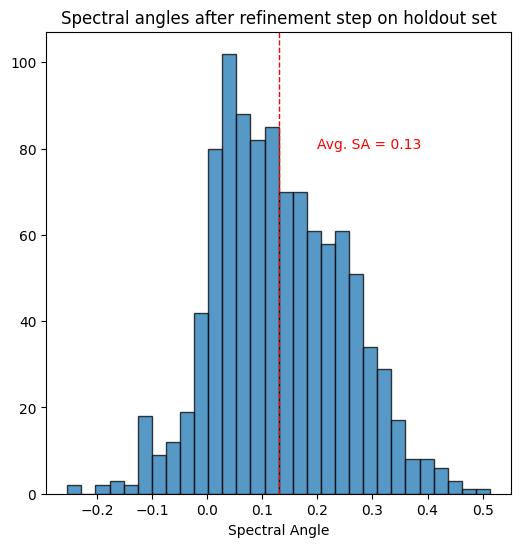

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
sa_small = [1 - sd for sd in sd_small]
avg_sa_scratch = np.mean(sa_small)
ax.hist(sa_small, bins=30, alpha=0.75, edgecolor='black')
ax.axvline(avg_sa_scratch, color='r', linestyle='dashed', linewidth=1)
ax.text(0.2, 8e1, f'Avg. SA = {avg_sa_scratch:.2f}', color='r')
ax.set_title(f'Spectral angles after refinement step on holdout set')
ax.set_xlabel('Spectral Angle')